In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from vae import Base, LMCVAE
from samplers import HMC, run_chain
from distributions import (
    Banana,
)
#import yaml
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

%matplotlib widget

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [8]:
n_steps = 1
dist = "banana"
dim = 100
scale_proposal = 1.
scale_isir = 5.
dist_class = "Banana"
dist_params = {
    "b": 0.02,
    "sigma":5.0,
}
sigma = 5.0
b = 0.02

In [9]:
# Данные
target = Banana(
                dim=dim,
                device=device,
                b = b,
                sigma = sigma,
                #b = b
                #**dist_params.dict,
)

loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)

# proposal = IndependentNormal(
#     dim=dim,
#     loc=loc_proposal,
#     scale=scale_proposal,
#     device=device,
# )

# proposal_ex2 = IndependentNormal(
#     dim=dim,
#     loc=loc_proposal,
#     scale=scale_isir,
#     device=device,
# )

In [10]:
class Banana_Dataset(Dataset):
    def __init__(self, data):
        super(Banana_Dataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = torch.tensor(self.data[item], dtype=torch.float32, device=device)
        return sample, -1.

## Generate ground-truth samples

In [11]:
N_samples = 2*10**3
np.random.seed(42)
True_samples = np.random.randn(N_samples,dim)
for i in range(dim):
    if i % 2 == 0:
      True_samples[:,i] *= sigma
    else:
      True_samples[:,i] += b*True_samples[:,i-1]**2 - (sigma**2)*b

In [12]:
banana = Banana_Dataset(True_samples)

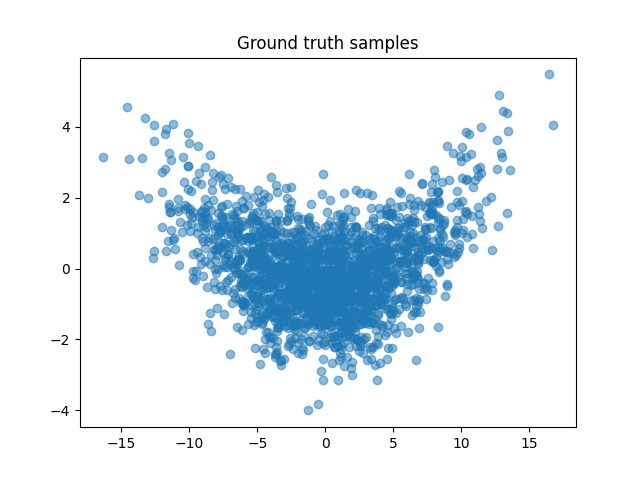

In [13]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,2],True_samples[:,3], alpha=0.5)
ax.set_title('Ground truth samples')
plt.show()

## Model

In [25]:
latent_dim = 4*dim
class BananaEncoder(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 4*d),
            nn.LeakyReLU(),
            nn.Linear(4*d, 2),
        )

    def forward(self, x):
        return self.net(x)

    
class BananaDecoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 4*d),
            nn.LeakyReLU(),
            nn.Linear(4*d, 2),
        )

    # @property
    # def alpha(self,):
    #     return torch.exp(self.log_alpha)
    
    # @property
    # def beta(self,):
    #     return torch.exp(self.log_beta)

    def forward(self, x):
        return self.net(x)
    
class TrueDecoder(nn.Module):
    def __init__(self, sigma, b, eps=None):
        super().__init__()
        self.register_buffer('eps', torch.tensor(eps, dtype=torch.float32))
        #self.aux = nn.Parameter(torch.tensor(0., dtype=torch.float32))
        self.b = b
        self.sigma = sigma

    def forward(self, z):
        True_samples = np.random.randn(z.size()[0], z.size()[1])
        for i in range(z.size(1)):
            if i % 2 == 0:
                True_samples[:,i] *= sigma
            else:
                True_samples[:,i] += b*True_samples[:,i-1]**2 - (sigma**2)*b
        return torch.tensor(True_samples)
        
        #return 2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.) # + t

In [26]:
def generate_dataset(N_samples, dim, sigma=1.):
    np.random.seed(42)
    True_samples = np.random.randn(N_samples, dim)
    for i in range(dim):
        if i % 2 == 0:
            True_samples[:,i] *= sigma
        else:
            True_samples[:,i] += b*True_samples[:,i-1]**2 - (sigma**2)*b
    return True_samples


class Toy(Base):   
    def joint_logdensity(self, use_true_decoder=None):
        def density(z, x):
            if (use_true_decoder is not None) and use_true_decoder:
                x_reconst = self(z)
            elif hasattr(self, 'use_cloned_decoder') and self.use_cloned_decoder:
                x_reconst = self.cloned_decoder(z)
            else:
                x_reconst = self(z)
            log_Pr = torch.distributions.Normal(loc=torch.tensor(0., device=x.device, dtype=torch.float32),
                                    scale=torch.tensor(1., device=x.device, dtype=torch.float32)).log_prob(
                    z).sum(-1)
            
            return torch.distributions.Normal(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2) + 0. * self.decoder_net.aux,
                                                  scale=self.decoder_net.sigma).log_prob(x).sum(-1) + log_Pr

        return density
    
    
class LMCVAE_Toy(LMCVAE, Toy):
    def loss_function(self, sum_log_weights):
        loss = super(LMCVAE_Toy, self).loss_function(sum_log_weights)

        return loss

In [27]:
N = 10000
d = 2
sigma = 1.
eps = 2 + np.random.randn(1, d)
X_train = generate_dataset(N_samples=N, dim=d, sigma=sigma)
X_val = generate_dataset(N_samples=N // 100, dim=d, sigma=sigma)
train_dataset = Banana_Dataset(data= X_train)
val_dataset = Banana_Dataset(data=X_val)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [28]:
X_train.shape

(10000, 2)

In [32]:
def replace_enc_dec(model):
    model.encoder_net = BananaEncoder(d=d)
    print("sosi")
    model.decoder_net = BananaDecoder(d=d)
    #model.decoder_net = TrueDecoder(d=d, eps=eps, sigma=sigma)
    model = model.to(device)
    return model

In [33]:
seed_everything(42)
lmcvae = LMCVAE_Toy(shape=2, act_func=nn.LeakyReLU,
            num_samples=1, hidden_dim=2,
            net_type='conv', dataset='toy',
            step_size=0.01, K=5, use_transforms=False, learnable_transitions=False, return_pre_alphas=True, use_score_matching=False,
                      ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=True,
                     acceptance_rate_target=0.9, annealing_scheme='all_learnable')
lmcvae = replace_enc_dec(lmcvae)
lmcvae.name = 'LMCVAE'

sosi


/home/kolesiks/projects/adaptive-mcmc/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [34]:
def run_trainer(model):
    seed_everything(42)
    tb_logger = pl_loggers.TensorBoardLogger('lightning_logs/')
    trainer = pl.Trainer(logger=tb_logger, fast_dev_run=False, max_epochs=16, ) #automatic_optimization=True
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [35]:
run_trainer(lmcvae)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name            | Type          | Params
--------------------------------------------------
0 | encoder_net     | BananaEncoder | 42    
1 | decoder_net     | BananaDecoder | 42    
2 | transitions_nll | ModuleList    | 8     
3 | transitions     | ModuleList    | 5     
  | other params    | n/a           | 5     
--------------------------------------------------
89        Trainable params
13        Non-trainable params
102       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kolesiks/projects/adaptive-mcmc/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x1 and 2x8)

In [ ]:
n_leapfrogs = 5
step_size = 0.01
n_samples = 10000
hmc = HMC(n_leapfrogs=n_leapfrogs, step_size=step_size, partial_ref=False, use_barker=False).to(device)
X_item = torch.tensor([[2 * np.pi * (2. + 2.)]], device=device, dtype=torch.float32)

In [ ]:
## Receive true posterior sample:
def target_density(z):
    even = np.arange(0, dim, 2)
    odd = np.arange(1, dim, 2)

    ll = -0.5 * (
        z[..., odd] - b * z[..., even] ** 2 + (sigma**2) * b
    ) ** 2 - ((z[..., even]) ** 2) / (2 * sigma**2)
    return ll.sum(-1)

# target_density = lambda z, x: torch.distributions.Normal(loc=2 * np.pi * (torch.sqrt(torch.sum(torch.pow(z, 2), dim=1, keepdim=True)) + 2.), scale=sigma).log_prob(X_item.repeat(n_samples, 1)).sum(
#     -1) + torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
#                                      scale=torch.tensor(1., device=device, dtype=torch.float32)).log_prob(z).sum(-1)

true_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, 2, device=device), target=target_density, return_trace=False, n_steps=1, burnin=500).cpu().numpy()

In [ ]:
def receive_model_samples(model, X_item, stacked=False):
    with torch.no_grad():
        x = X_item
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=n_samples)
        if model.name in ['LMCVAE', 'AMCVAE']:
            model_samples_init = model_samples
            model_samples = model.run_transitions(z=model_samples, x=x.repeat(n_samples, 1), mu=mu, logvar=logvar)[0]
        elif model.name in ['VAE_with_Flows']:
            model_samples = model.Flow(model_samples)[0]
    return model_samples.cpu().numpy()

def plot_contours(model, X_item, stacked=False, graph=None):
    x = X_item
    with torch.no_grad():
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=n_samples)
        logprobs = torch.distributions.Normal(loc=mu, scale=torch.exp(0.5 * logvar)).log_prob(model_samples).sum(-1)
#     plt.contour(model_samples[:, 0].cpu()[..., None], model_samples[:, 1].cpu()[..., None], logprobs.cpu()[..., None])
    if graph is None:
        plt.scatter(model_samples[:, 0].cpu(), model_samples[:, 1].cpu(),)
    else:
        graph.x = model_samples[:, 0].cpu()
        graph.y = model_samples[:, 1].cpu()
        graph.plot_joint(plt.scatter, marker='x', c='g', s=50, alpha=0.5)
    

def receive_posterior_samples(model, n_samples, stacked=False):
    with torch.no_grad():
        model_target_density = lambda z, x: model.joint_logdensity()(z=z, x=X_item.repeat(n_samples, 1))
        model_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, 2, device=device), target=model_target_density, return_trace=False, n_steps=1, burnin=500).cpu().numpy()
    return model_posterior_samples

In [ ]:
lmcvae_sample = receive_model_samples(lmcvae, X_item)
lmcvae_posterior_sample = receive_posterior_samples(lmcvae, n_samples)

In [ ]:
# plot
# ========================================
graph = sns.jointplot(x=true_posterior_samples[:, 0], y=true_posterior_samples[:, 1], color='r', alpha=0.5);
# graph = sns.jointplot(x=vae_posterior_sample[:, 0], y=vae_posterior_sample[:, 1], color='r', alpha=0.5);
# graph = sns.jointplot(x=iwae_posterior_sample[:, 0], y=iwae_posterior_sample[:, 1], color='r', alpha=0.5);
# graph = sns.jointplot(x=lmcvae_posterior_sample[:, 0], y=lmcvae_posterior_sample[:, 1], color='r', alpha=0.5);
# graph = sns.jointplot(x=amcvae_posterior_sample[:, 0], y=amcvae_posterior_sample[:, 1], color='r', alpha=0.5);
# graph = sns.jointplot(x=flows_vae_posterior_sample[:, 0], y=flows_vae_posterior_sample[:, 1], color='r', alpha=0.5);

graph.x = lmcvae_sample[:, 0]
graph.y = lmcvae_sample[:, 1]
graph.plot_joint(plt.scatter, marker='x', c='y', s=50, alpha=0.1)

# plt.xlim(-5., 5.)
# plt.ylim(-5., 5.)
# plt.axis('equal');


# plot_contours(model=stacked_vae, X_item=X_item, stacked=True)

In [ ]:
def plot_heatmap(samples, x_limits, y_limits, title=None, gamma=0.75, name='default.png'):
    import matplotlib.colors as mcolors
    from scipy.stats import kde
    plt.close()
    plt.figure(figsize=(5, 5), dpi=300)
    
    x = samples[:, 0]
    y = samples[:, 1]
    nbins = 300
    k = kde.gaussian_kde([x,y], bw_method=0.1)
    xi, yi = np.mgrid[x_limits[0]:x_limits[1]:nbins*1j, y_limits[0]:y_limits[1]:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Make the plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
    plt.axis('off')
    plt.xlim((x_limits[0], x_limits[1]))
    plt.ylim((y_limits[0], y_limits[1]))
#     plt.axis('equal')
    plt.tight_layout()
    plt.savefig(name, format='png')
    plt.show()

In [ ]:
plot_heatmap(true_posterior_samples, (-4, 4), (-4, 4), title=None, gamma=0.5, name='true_posterior.png')

In [ ]:
plot_heatmap(lmcvae_sample, (-4, 4), (-4, 4), title=None, gamma=0.5, name='lmcvae.png')